# DC-Biking State Usage Prediction Based On Weather

### 15688 Team Project 

Bowen Yang (boweny1), I-Huei Huang (ihueih), Gilbert Gao (bog)

# Motivation
Traffic flow prediction can be difficult because of its randomness natural. However, if we can predict the bike requirements, it will be helpful to schedule bikes for a bike rental system. In our team project, we will leverage the dataset provided by [Capital Bikeshare](https://www.capitalbikeshare.com/) system located at Washington D.C. as well as the historical weather data queried from the [Weather Underground history API](https://www.wunderground.com/weather/api/d/docs?d=data/history) .

By combining these data together, we plan to build a machine learning model that take historical bike using data and weather information as input and make prediction on total number of bikes required in Washington D.C. based on features of weather and the location of the bike station.

# Report Contents
* [Prerequisite](#Prerequisite)
* [Phase 1: Clean out the history bike data](#pp1)
* [Phase 2: Collect weather information -- weather underground API](#pp2) 
* [Phase 3: Station cluster](#pp3)
* [Phase 4: Merging bike sharing data and weather data](#pp4)
* [Phase 5: Feature Generation](#pp5)
* [Phase 6: Model Selection](#pp6)
* [Phase 7: Running the Adaboost Decision Tree Model & Result analysis](#pp7)
* [Phase 8: Conclusion](#pp8)
* [Reference](#pp9)

# Prerequisite
Download [history data from 2011 to 2015](https://s3.amazonaws.com/capitalbikeshare-data/index.html) from [Capital BikeShare](https://www.capitalbikeshare.com/trip-history-data).

Since the dataset is located in s3 storage, after configure the AWS Command Line Interface, we can download the whole dataset in a single line:

`$ aws s3 cp s3://capitalbikeshare-data . --recursive`


# Phase 1: Clean out the history bike data <a id = "pp1"></a>

Then we can start to clean out the history bike data. 

First we need to parse the station information from the XML file downloaded in the website. 

In [1]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import cross_validation
import csv
import os
import math
import calendar
from datetime import datetime
from math import log
import plotly.plotly as py
import plotly.tools as tls
from pandas.tseries.holiday import USFederalHolidayCalendar as cld

/Users/Gilbert1/anaconda3/envs/Python27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
soup = BeautifulSoup(open("stations.xml"), "lxml")
station_list = soup.find_all('station')

The `station_list` is where we save all the station tag informations. We can print one of them to see what's inside to make ourselves clear about how to parse it.

In [19]:
print station_list[0]

<station><id>1</id><name>Eads St &amp; 15th St S</name><terminalname>31000</terminalname><lastcommwithserver>1478040900207</lastcommwithserver><lat>38.858971</lat><long>-77.05323</long><installed>true</installed><locked>false</locked><installdate>0</installdate><removaldate></removaldate><temporary>false</temporary><public>true</public><nbbikes>6</nbbikes><nbemptydocks>8</nbemptydocks><latestupdatetime>1478040899170</latestupdatetime></station>


Then now we can generate a dataframe to get the needed information and save into a csv file.

In [5]:
result = []
for each_tag in station_list:
    station_dict = {}
    station_dict['id'] = each_tag.id.string
    station_dict['name'] = each_tag.find('name').string
    station_dict['terminalname'] = each_tag.terminalname.string
    station_dict['lat'] = float(each_tag.lat.string)
    station_dict['long'] = float(each_tag.find('long').string)
    result.append(station_dict)
station_df = pd.DataFrame.from_dict(result)

In [6]:
print station_df.head()
station_df.to_csv('station.csv', index=False)

  id        lat       long                                        name  \
0  1  38.858971 -77.053230                         Eads St & 15th St S   
1  2  38.857250 -77.053320                             18th & Eads St.   
2  3  38.856425 -77.049232                           20th & Crystal Dr   
3  4  38.860170 -77.049593                           15th & Crystal Dr   
4  5  38.857866 -77.059490  Aurora Hills Community Ctr/18th & Hayes St   

  terminalname  
0        31000  
1        31001  
2        31002  
3        31003  
4        31004  


Then we move to the raw bike data to parse the useful information. 
First, we need the help from `glob` to get all the data files:

In [8]:
all_historical = glob.glob("*-cabi-trip-history-data.csv")

For our analysis, we only care about when and where the bike riders start their travel. Therefore we filter out all the unuseful information for us to simplify the parsing data size.

In [9]:
historical_df_list = []
for each_file in all_historical:
    temp_df = pd.read_csv(each_file)
    temp_df.columns = [each.lower() for each in temp_df.columns]
    if 'start station number' in temp_df.columns:
        # This is a updated version of dataset
        temp_df = temp_df[['start date','start station','start station number']]
        historical_df_list.append(temp_df)
    else:
        # older ones 
        temp_df = temp_df[['start date','start station']]
        historical_df_list.append(temp_df)

The original data comes with multiple date format. To organize and for future merging usage, we need to parse the dates to have same output format.

In [10]:
# Parse the dates
for each_df in historical_df_list:
    each_df['start date'] =  pd.to_datetime(each_df['start date'], infer_datetime_format = True)

The other messy part is that some of the station name does not only contains the name, but also the changed station name (represented by '[]') and the station terminal name (represented by the '()'). So a parsing using regular expression is needed. 

The changed station is saved for future use.

In [16]:
station_change = []
for each_df in historical_df_list:
    # Filter out the changed names
    extract_start = each_df['start station'].str.extract('(?P<extracted>[^\[\]]+) *(?P<change>\[[^\[\]]+\])? *', expand=False)
    new_start = extract_start.extracted.apply(lambda x: str(x).rstrip())
    each_df['start station'] = new_start
    # Then get the station change
    if extract_start.shape[1] > 1:
        station_change.append(extract_start.dropna(how='any').drop_duplicates())

Now we started to merge the station information with the historical travel data.

In [17]:
station_df = pd.read_csv('station.csv')
print station_df.columns
useful_station_df = station_df[[u'lat', u'long', u'name', u'terminalname']]
print useful_station_df.dtypes
print historical_df_list[-1].dtypes

Index([u'id', u'lat', u'long', u'name', u'terminalname'], dtype='object')
lat             float64
long            float64
name             object
terminalname      int64
dtype: object
start date              datetime64[ns]
start station                   object
start station number             int64
dtype: object


The data sets are not consistant for all these years. Some of the 

In [20]:
combined = []
# Find the useful information from the station_df
for each_df in historical_df_list:
    if "start station number" in each_df.columns:
        # merge on the numbers
        merged = each_df.merge(useful_station_df, left_on='start station number', right_on='terminalname', how='inner')
        combined.append(merged[['start date','start station','terminalname', 'lat', 'long']])
    else:
        # have to merge on the names:
        merged = each_df.merge(useful_station_df, left_on='start station', right_on='name', how='inner')
        combined.append(merged[['start date','start station','terminalname', 'lat', 'long']])

After merging, we can `concat` the list of dataframes and generate a master dataset for future usage. 

In [21]:
total_df = pd.concat(combined)
print total_df.shape

(11815281, 5)


In [ ]:
total_df.to_csv("merged_data.csv", index = False, date_format ="%m/%d/%Y %H:%M")

So now we have a historical travel dataset ready for merge and future manipulation. 

We are curious about how the weather information have influence the usage of the bike trips. Since we now have the travel data, we can move to the weather data retrieving. 

# Phase 2: Collect weather information -- weather underground API  <a id = "pp2"></a>
We collect historical weather information from 2011 to 2015 by calling history weather API on [Weather Underground](https://www.wunderground.com/weather/api/d/docs?d=data/history).
After downloading [history data from 2011 to 2015](https://s3.amazonaws.com/capitalbikeshare-data/index.html) from [Capital BikeShare](https://www.capitalbikeshare.com/trip-history-data), and applied API form wunderground.com. We extract the start date of each trip and call the API:
    __http://api.wunderground.com/api/{APIkey}/history_YYYYMMDD/q/DC.json__
to get the weather information in that day. And then, we parse the json format to get the weather at an exact hour in that day.
The following is the python script we used in this process:

First we include the packages we need:

In [ ]:
import requests
import json
import csv
import time

Then, we extract the weather information from 2011 to 2015 by calling weather undergound history API.

In [ ]:
key = 'your_api_key'
years = ['2011', '2012', '2013', '2014', '2015']
seasons = ['Q1', 'Q2', 'Q3', 'Q4']

for y in years:
    for s in seasons:
        # create log file
        logfile = "weather/log_" + y + "_" + s + ".txt"
        log = open(logfile, "wb")
        
        # create read and write file
        rfile = 'data/' + y + '-' + s + '-cabi-trip-history-data.csv'
        wfile = 'weather/' + rfile.split('/')[1].split('.')[0] +  '-weather.csv'
        csvrfile = open(rfile, 'rb')
        csvwfile = open(wfile, 'wb')
        
        # read csv file
        reader = csv.DictReader(csvrfile)
        rfieldnames = reader.fieldnames
        
        # write csv file
        wfieldnames = ['Start date', 'Weather type', 'Temperature', 'Humidity', 'Wind speed']
        writer = csv.DictWriter(csvwfile, fieldnames=wfieldnames)
        writer.writeheader()
        
        # store the time we have already visited to increase performance
        visit = set()
        for row in reader:
            d = {}
            # check the format of the date is valid: MM/DD/YYYY hh:mm
            if '/' not in row['Start date']:
                date_and_time = row['Start date'].split()
                mdate = date_and_time[0]
                num = mdate.split('-')
                mdate = num[1] + '/' + num[2] + '/' + num[0]
                mtime = date_and_time[1]
                row['Start date'] = mdate + ' ' + mtime
                
            # extract the date we need to call weather API    
            t = row['Start date']
            t = t.split()

            try:
                date = t[0].split('/') 
                year = int(date[2])
                mon = int(date[0])
                mday = int(date[1])
                date = str(year) + '%02d' % mon + '%02d' % mday
                t = t[1].split(':')
                hour = int(t[0])
                key = date + ":" + str(hour)
                if key in visit:
                    continue
                visit.add(key)
            except:
                print row['Start date']
                continue
            
            # begin to call weather API
            get = False
            while not get:
                try:
                    url = 'http://api.wunderground.com/api/' + key + '/history_' + date + '/q/DC.json'
                    r = requests.get(url)
                    parsed_json = json.loads(r.text)
                    observations = parsed_json["history"]["observations"]
                    get = True
                except:
                    time.sleep(100)
        
            # find the weather information at the exact hour we need
            for info in observations:

                if int(info["date"]["year"]) == year and int(info["date"]["mon"]) == mon and int(
                        info["date"]["mday"]) == mday and int(info["date"]["hour"]) == hour:
                    try:
                        d['Weather type'] = info["icon"]
                        d['Temperature'] = info["tempm"]
                        d['Humidity'] = float(info["hum"]) / 100
                        d['Wind speed'] = info["wspdm"]
                    except:
                        print year, mon, mday, hour
                        print info["icon"]
                        print info["tempm"]
                        print info["hum"]
                        print info["wspdm"]
                    break
                
            d['Start date'] = row['Start date'].split(':')[0]
            
            # If the data is missing, we discard the record, else write it to output file
            if len(d) != 5:
                print date + ":" + str(hour)
                log.write(date + ":" + str(hour)+ "\n")
            else:
                writer.writerow(d)
                
        print y + "-" + s + " finished"
        log.write(y + "-" + s + " finished\n")

The weather information collected is with the following format:

|  Start date     |  Weather Type	|   Temperature   |    Humidity     |   Wind Speed    |
|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|
| 01/01/2014 0    |	    clear	    |      1.1	      |       0.46      |   0             |
| 01/01/2014 1	  |    partlycloudy |      -1.1	      |       0.61      |   13            |
| 01/01/2014 2	  |    partlycloudy |      -0.6	      |       0.57      |   5.6           |

After we collect all the data, we need to encode Weather Type to convert to numerical data.

In [ ]:
import os
import pandas as pd
dname = "./data/weather"
data = pd.DataFrame()
filenames = [fname for fname in os.listdir(dname) if fname.endswith(".csv")]
columns = ['Start date', 'Weather type', 'Temperature', 'Humidity', 'Wind speed']
lst = []
for filename in filenames:
    frame = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    frame = frame.dropna()
    data = data.append(frame, ignore_index=True)


print "concat"
print data.head()
types = set(data['Weather type'])
print types
data = data.dropna()
data = data[data['Weather type'] != "unknown"]
types = set(data['Weather type'])
type_map = {}
print types

for i, type in enumerate(list(types)):
    type_map[type] = i
encode_type = lambda x : type_map[x]

encode = "./data/weather/merged/encode.txt"
wfile = open(encode, "wb")
wfile.write(str(type_map))

print data.head()
data['Weather type'] = data['Weather type'].apply(encode_type)
print data.head()
data.to_csv("./data/weather/merged/weather.csv", index=False)
print len(data)

We convert the weather type through the mapping below:

|  Weather Type   |    Type Label	|
|:---------------:|:---------------:|
|  mostlycloudy   |	       0        |
|  partlycloudy   |        1        |
|      clear      |        2        |
|      snow       |        3        |
|     cloudy      |        4        |
|      hazy       |        5        |
|     sleet       |        6        |
|    tstorms      |        7        |
|      fog        |        8        |
|      rain       |        9        |     

# Phase 3: Station cluster <a id = "pp3"></a>

There are so many stations in the District of Columbia, and they are growing through out the time. It will be difficult and not realistic for us to generate a prediction for all the stations. 

However, we still want to know a district-related information. So we make our decision to do a k-means cluster. 

First we need to check the geographic distribution of the stations.

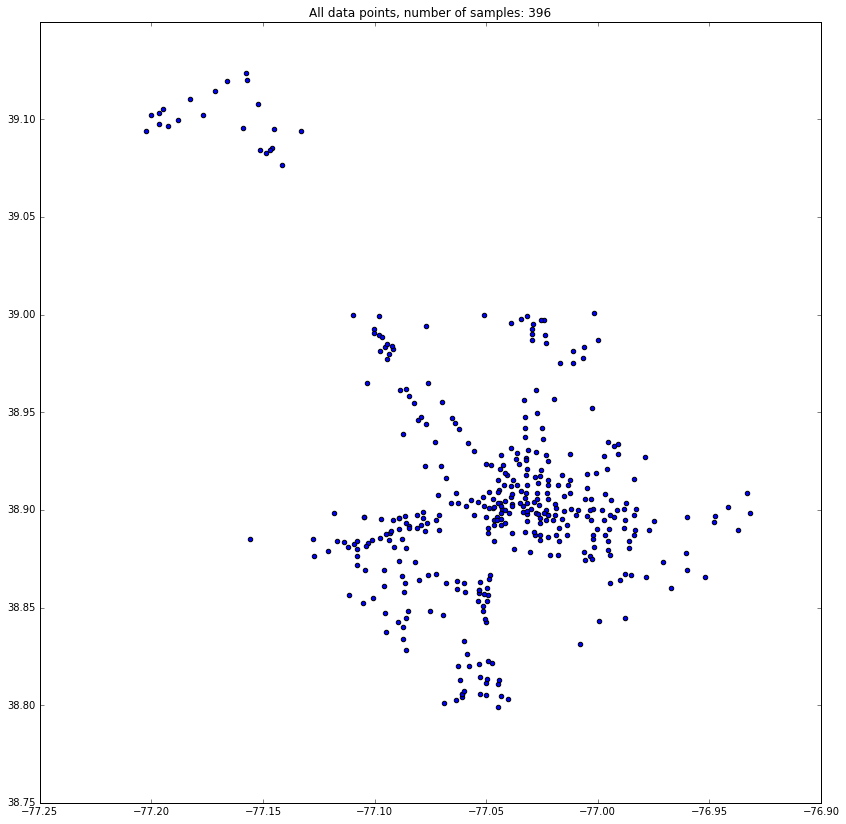

In [5]:
data = pd.read_csv("merged_data.csv", parse_dates=[0], infer_datetime_format=True)
stations = data[['start station', 'terminalname', 'lat', 'long']]
stations_unique = stations.drop_duplicates()
# To be change to draw picture on map
plt.figure(figsize=(14, 14))
plt.title('All data points, number of samples: %d' %len(stations_unique))
plt.scatter(stations_unique['long'], stations_unique.lat)
plt.show()

As we all know, the K-means algorithm is inconsistant on doing clusters, so we tried multiple times on the clustering and manually pick the best one we find makes sense as our result.

The following code is just a present of how we generate the cluster. The cluster we used is loaded and plotted later.

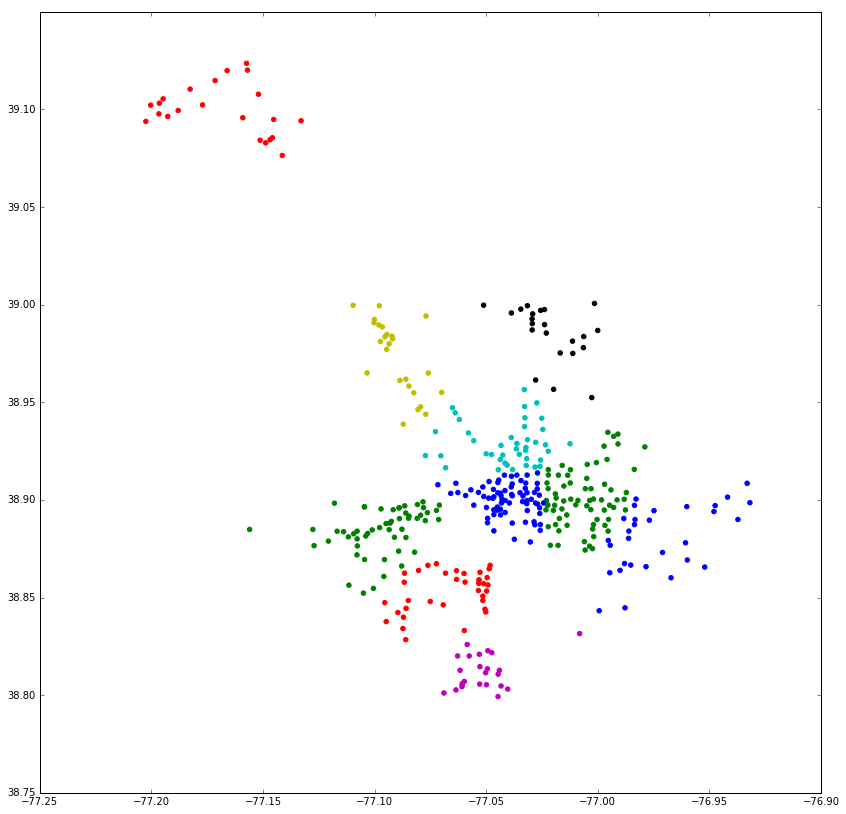

In [6]:
data = stations_unique[['long', 'lat']]
kmeans = KMeans(n_clusters=10)
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
kmeans_label = kmeans.fit_predict(data)
plt.figure(figsize=(14, 14))
plt.scatter(data['long'], data['lat'], color=colors[kmeans_label].tolist())
plt.show()


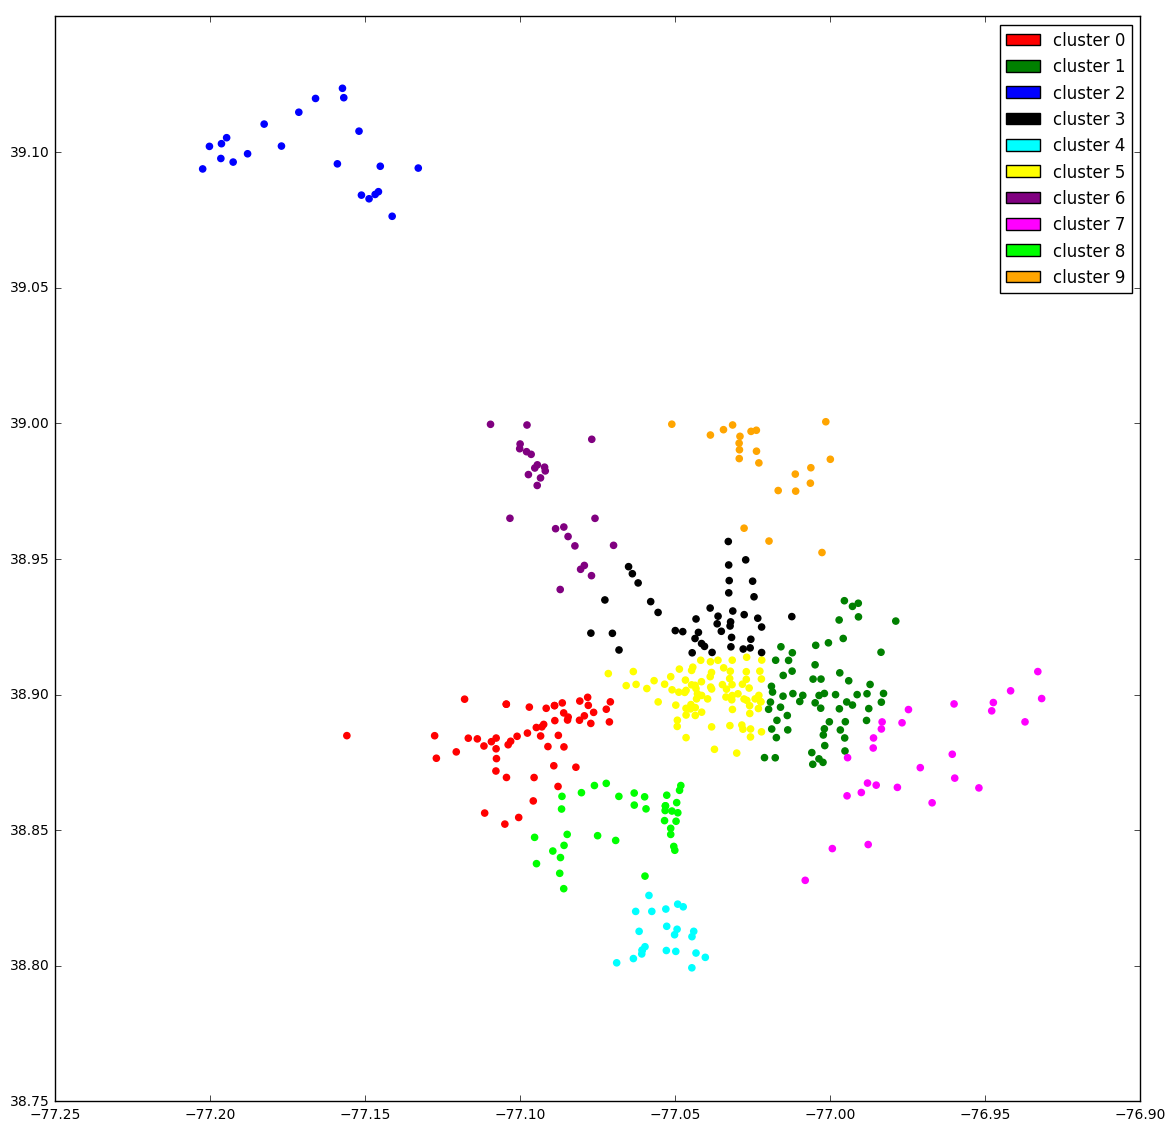

In [3]:
import matplotlib.patches as mpatches

stations_unique = stations_unique.assign(label = kmeans_label)

# stations_unique.to_csv("station_with_label.csv", index=False)
stations_unique = pd.read_csv("station_with_label.csv")

# plot refined_cluster
refined_cluster = pd.read_csv("station_with_label.csv")
colors = np.array(['red', 'green', 'blue', 'black', 'cyan', 'yellow', 'purple', 'magenta', 'lime', 'orange'])
plt.figure(figsize=(14, 14))

plt.scatter(refined_cluster['long'], refined_cluster['lat'], color=colors[refined_cluster['label']].tolist())
p_list = []
clss = []
for c in colors:
    p = plt.Rectangle((0, 0), 0.0, 0.0, fc=c)
    p_list.append(p)
    
plt.legend(p_list, ('cluster 0','cluster 1','cluster 2','cluster 3','cluster 4','cluster 5',
                     'cluster 6','cluster 7','cluster 8', 'cluster 9'), loc='best')
# plt.scatter(lg, lt, c = cls)
plt.show()

<img src="graph/dc_gmap.png">

Compare diagram of clusters and D.C. map from Google Map with same map scale, we could have a intuitive view of which cluster belongs to suburb and which cluster belongs to city, the view would help for our analysis in the later phase.

# Phase 4: Merging bike sharing data and weather data <a id = "pp4"></a>

Now we have the stations label for each label. But for each of the data point, we haven't assign the corelated cluster label to it yet. So the first step of the merging is to merge label to each data point.



In [8]:
alldata = pd.read_csv("merged_data.csv", parse_dates=[0], infer_datetime_format=True)
useful_for_merge = stations_unique[['terminalname', 'label']]
merged = alldata.merge(useful_for_merge, on='terminalname', how='inner')
print merged.head()

           start date   start station  terminalname       lat      long  label
0 2010-12-31 20:02:00  17th & K St NW         31213  38.90276 -77.03863      5
1 2010-12-31 17:37:00  17th & K St NW         31213  38.90276 -77.03863      5
2 2010-12-31 13:54:00  17th & K St NW         31213  38.90276 -77.03863      5
3 2010-12-31 11:49:00  17th & K St NW         31213  38.90276 -77.03863      5
4 2010-12-31 11:50:00  17th & K St NW         31213  38.90276 -77.03863      5


As we mentioned at the very beginning of this report, we are trying to predict all the bicycle usage of a certain area in a time range. Yet up to now, all we have is every single using record of every trip record. 

So now what we will do is to aggregate the trip record in every single hour. We use the time which is accurate to every hour as the column we use to do the aggregation. Then we count the number of trips in each cluster in each hour and output the result.

In [9]:
picked = merged[['start date', 'terminalname', 'label']]
# picked.to_csv("data_with_label.csv", index=False, date_format ="%m/%d/%Y %H")
date_string = picked['start date'].apply(lambda x: x.strftime("%m/%d/%Y %H"))
to_be_agg = picked.assign(date = date_string)
to_be_agg_small = to_be_agg[['label', 'date']]
new_group_by_date_label = pd.DataFrame({'count' : to_be_agg_small.groupby(['date', 'label']).size()}).reset_index()

One more thing which is good on aggregate on hour is that the hourly aggregated information can meet the weather data we gathered in previous phase. Since we could only get the hourly weather, it is the best choice for us to merge the bicycle data with weather on the hour.

So the following is how we merge the weather data with the bicycle usage count data.

In [10]:
weather = pd.read_csv("weather.csv", parse_dates=[0], infer_datetime_format=True)
weather_date_string = weather['Start date'].apply(lambda x: x.strftime("%m/%d/%Y %H"))
weather_with_string = weather.assign(date = weather_date_string)
weather_to_be_merged = weather_with_string[["date","Weather type", "Temperature", "Humidity" ,"Wind speed"]]
final_merged = new_group_by_date_label.merge(weather_to_be_merged, on = 'date', how='inner')
# final_merged.to_csv("data_with_label_and_weather.csv", index=False)

Now we have the data with both cluster label and weather information. But for the ease of our analysis, we also want to see the data of all the bicycles at D.C. at every hour. Therefore we need to merge all the clusters together for each hour. That's exactly what we do now.

In [14]:
data = pd.read_csv("data_with_label_and_weather.csv", parse_dates=[0], infer_datetime_format=True)
sub_data = data[["date", "count"]]
new_group_by_date = pd.DataFrame({'count_sum' : sub_data.groupby(['date'])['count'].sum()}).reset_index()
data_date_string = new_group_by_date['date'].apply(lambda x: x.strftime("%m/%d/%Y %H"))
data_with_string = new_group_by_date.assign(date_str = weather_date_string)
data_to_be_merged = data_with_string[["date_str", "count_sum"]]

simple_merge = new_group_by_date.merge(weather, left_on="date", right_on="Start date", how = 'inner')
hour = simple_merge['date'].apply(lambda x: x.strftime("%H"))
newdate = simple_merge['date'].apply(lambda x: x.strftime("%m/%d/%Y"))
simple_merge_add = simple_merge.assign(hour = hour, newdate = newdate)
output_data = simple_merge_add[["newdate", "hour","count_sum", "Weather type", "Temperature", "Humidity", "Wind speed"]]
# output_data.to_csv("city_wise_data_with_weather.csv", index=False)
print output_data.head()

      newdate hour  count_sum  Weather type  Temperature  Humidity  Wind speed
0  01/01/2011   01          1             2          2.2      0.82         0.0
1  01/01/2011   13          4             4         14.0      0.77        18.5
2  01/01/2011   14          1             4         12.8      0.77        20.4
3  01/01/2011   15          2             4         11.7      0.83        20.4
4  01/01/2011   16          2             4         12.0      0.82        20.4


For easily analyze each cluster, we also generated the data for each cluster. 

In [13]:
data = pd.read_csv("data_with_label_and_weather.csv", parse_dates=[0], infer_datetime_format=True)
hour = data['date'].apply(lambda x: x.strftime("%H"))
newdate = data['date'].apply(lambda x: x.strftime("%m/%d/%Y"))
new_data = data.assign(hour = hour, newdate = newdate)
selected = new_data[["newdate", "hour", "label", "count", "Weather type", "Temperature", "Humidity", "Wind speed"]]
result = []
for i in range(10):
    each = selected[selected['label'] == i]
#     each.to_csv("cluster_"+ str(i) +"_data_with_weather.csv", index=False)
print each.head()

        newdate hour  label  count  Weather type  Temperature  Humidity  \
294  01/01/2014   09      9      1             4          2.8      0.52   
303  01/01/2014   10      9      1             1          4.4      0.53   
311  01/01/2014   11      9      1             0          5.0      0.55   
337  01/01/2014   14      9      5             0          8.9      0.44   
346  01/01/2014   15      9      2             0          8.9      0.48   

     Wind speed  
294        13.0  
303        16.7  
311        13.0  
337        13.0  
346        14.8  


# Phase 5: Feature Generation <a id = "pp5"></a>

Since we have all the data now, we need to feed in the model in a right way. There are several aspect we need to consider here. 

First, we want to take the date related features out. 

Second, we would like to normalize the input data

Last, we need to have all the train and test functions

We generate the following features from our data:

|  feature #  |  feature name     |   data type    |         description                |  
|:-----------:|:-----------------:|:--------------:|:----------------------------------:|
|      1      |  weather_type     |     int        | encoded weather type               |
|      2      |    year           |     int        | encoded year (year - 2010)         |
|      3      |    label          |     int        | cluster ID                         |
|      4      |    weekday        |     int        | weekday(1) or weekend(0)           |
|      5      |    holiday        |     int        | US holiday(1) or not US holiday(0) |
|      6      |  temperature      |    float       | normalized temperature             |
|      7      |  humidity         |    float       | normalized humidity                |
|      8      |  wind_speed       |    float       | normalized wind speed              |
|      9      |  day_of_year      |    float       | sin and cos values                 |
|      10      |  day_of_week      |    float       | sin and cos values                 |
|      11     |  hour_of_day      |    float       | sin and cos values                 |
|      12     |  month_of_year    |    float       | sin and cos values                 |

Note that for temperature, humidity and wind speed, we take the normalized value (divided by the maximum value).

Since time is a cyclic variable, we use a sine/cosine transformation. Suppose we have a feature of value f that ranges from 0 to N. Then, the sine and cosine transformation would be $\sin\left(2\pi \frac{f}{N}\right)$ and $\cos\left(2\pi \frac{f}{N}\right)$



In [20]:
def convert_type(df):
    df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y")
    return df

def calculate_mse(x, y):
    return ((x - y) ** 2).mean()

def extract_year_range(df, start_year, start_month, end_year, end_month):
    return df.loc[(df['date'] >= str(start_year) + '-'+ str(start_month) +'-1') & (df['date'] < str(end_year) + '-'+ str(end_month) +'-1')].reset_index(drop=True)

def create_features(df):
    feature_df = pd.DataFrame()
    feature_df['count'] = df['count']
    feature_df['weather_type'] = df['weather_type']
    feature_df['label'] = df['label']
    # normalize
    feature_df['temperature'] = df['temperature'] / max(df['temperature'])
    feature_df['humidity'] = df['humidity'] / max(df['humidity'])
    feature_df['wind_speed'] = df['wind_speed'] / max(df['wind_speed'])
    # cyclic
    feature_df['sin_day_of_year'] = df['date'].map(lambda time: math.sin(
        2 * math.pi * datetime.date(time.to_datetime()).timetuple().tm_yday / 366) if calendar.isleap(
        time.to_datetime().year) else math.sin(
        2 * math.pi * datetime.date(time.to_datetime()).timetuple().tm_yday / 365))
    feature_df['cos_day_of_year'] = df['date'].map(lambda time: math.cos(
        2 * math.pi * datetime.date(time.to_datetime()).timetuple().tm_yday / 366.0) if calendar.isleap(
        time.to_datetime().year) else math.sin(
        2 * math.pi * datetime.date(time.to_datetime()).timetuple().tm_yday / 365.0))
    feature_df['sin_day_of_week'] = df['date'].map(
        lambda time: math.sin(2 * math.pi * time.to_datetime().weekday() / 7.0))
    feature_df['cos_day_of_week'] = df['date'].map(
        lambda time: math.cos(2 * math.pi * time.to_datetime().weekday() / 7.0))
    feature_df['sin_hour_of_day'] = df['hour'].map(
        lambda time: math.sin(2 * math.pi * time / 24.0))
    feature_df['cos_hour_of_day'] = df['hour'].map(
        lambda time: math.cos(2 * math.pi * time / 24.0))

    feature_df['weekday'] = df['date'].map(
        lambda time: 1 if time.to_datetime().weekday() <= 4 else 0)
    feature_df['year'] = df['date'].map(lambda time: time.to_datetime().year - 2010)
    feature_df['sin_month_of_year'] = df['date'].map(lambda time: math.sin(2 * math.pi * time.to_datetime().month / 12.0))
    feature_df['cos_month_of_year'] = df['date'].map(lambda time: math.cos(2 * math.pi * time.to_datetime().month / 12.0))
    cal = cld()
    holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
    feature_df['holiday'] = df['date'].isin(holidays).astype(int)
    return feature_df

Now we divide the data into train and test data.
Train is from 2012 to 2015 first half year, and test is 2015 second half year.

In [22]:
data_df = pd.read_csv("city_wise_data_with_weather.csv", parse_dates=[0], infer_datetime_format=True)
print data_df.columns, data_df.dtypes
data_df.columns = [u'date', u'hour', u'count', u'weather_type', u'temperature',
       u'humidity', u'wind_speed']
print data_df.columns

# Divide train and test
train = create_features(extract_year_range(data_df, 2012, 1, 2015, 6))
test = create_features(extract_year_range(data_df, 2015, 6, 2016, 1))
print train.shape, test.shape

Index([u'newdate', u'hour', u'count_sum', u'Weather type', u'Temperature',
       u'Humidity', u'Wind speed'],
      dtype='object') newdate         datetime64[ns]
hour                     int64
count_sum                int64
Weather type             int64
Temperature            float64
Humidity               float64
Wind speed             float64
dtype: object
Index([u'date', u'hour', u'count', u'weather_type', u'temperature',
       u'humidity', u'wind_speed'],
      dtype='object')
(29651, 16) (5118, 16)


# Phase 6: Model Selection <a id = "pp6"></a>

Model selection is a very important part of this project. We wanted to have a supervised model with the ability to quickly tuning the parameters to retrieve best result. 

We did our research and found a Master thesis. [1] In his paper, he tried several different models and finally draws the conclusion that adaboosted decision tree has the best result out of regular decision tree, random forest and adaboosted decision tree model. 

With this conclusion, we paid extra notice on tuning and making the adaboost decision tree model. Meanwhile, we also tried SVM model, which was not identified by that thesis.

Two model with the parameter tuning functions here. 

But before we do any implementation, we need to have the error function which is going to be used by tuning process. 
In this project, we choose **Root Mean Squared Logarithmic Error** (RMSLE) to be our tuning panalty function. 

The RMSLE error is defined as follows:

$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

It should be noted that we tend to more favorable to an overestimate bicycle usage count other than the underestimate one. Because we could afford some bicycle is not being used -- even though we definitely loves to have exact number of prediction -- other than to have shortage of bicycle when people need them. 

RMSLE error just have the same property as we want it to have: It penalizes an under-predicted estimate greater than an over-predicted estimate. This is the reason we pick it as the panalty function of the parameter tuning.


In [17]:
# Function to calculate RMSLE
def rmsle(estimatevalue, realvalue):
    result = np.mean((np.log(np.array(estimatevalue) + 1)-np.log(np.array(realvalue) + 1))**2)
    return np.sqrt(result)

Now we can start to tune the parameter of the Adaboost Decision Tree model. We first tried to use the package of the gridsearchCV function in the sklearn library. Yet it runs too slow so we have to implement the cross validataion from scretch. 

We also find the problem that there are in total 5 arguments for adaboosted decision tree. 3 for the decision tree and 2 for the adaboost. If we put them all together to tune, we would have a $O(n^5)$ time complexity and it is highly undesirable. 

Therefore, we use a two-step tuning here. First we tune the parameter of the decision tree model and find the best-fit out of the model. Then we use the best set of the parameters we have to tune the adaboost model. And that's where we finalized the parameter set. 

So now we would start with the decision tree model tuning.

The idea is simply using k-fold. For each combination of the parameters, we use cross validataion to have an average error of this parameter. Then find the set of parameter which has the smallest error and take it as our best fit.

It note to mention that we started from a larger range of parameter with larger step. Then find the smaller area of the parameters and have smaller range of parameter with smaller step. The choose of the following set is the last set of the choice.

In [18]:
def decision_tree_cv(df, maxTreeDepth, minTreeSplit, minTreeNodeSample, fold_num = 10):
    error = 0
    kf = cross_validation.KFold(df.shape[0], n_folds=fold_num)
    Bestset = [0,0,0]
    Errorset = []
    print "Start CV"
    for depth in maxTreeDepth:
        for split in minTreeSplit:
            for nodenum in minTreeNodeSample:
                avgerror = 0
                avgrmsderror = 0
                for train_index, test_index in kf:
                    # Get Train set & Test set
                    x_train, x_test = df.iloc[train_index].drop('count', axis = 1), df.iloc[test_index].drop('count', axis = 1)
                    y_train, y_test = df.iloc[train_index]['count'], df.iloc[test_index]['count']
                    # Acquire the Prediction of the data
                    clf = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=nodenum, min_samples_split=split)
                    # clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=depth, min_samples_leaf=nodenum, min_samples_split=split), n_estimators=300, random_state=rng)
                    clf = clf.fit(x_train, y_train)
                    estimatevalue = clf.predict(x_test)
                    #rmsderror = self.rmsd(estimatevalue, y_test)
                    error = rmsle(estimatevalue, y_test)
                    #print error
                    avgerror = avgerror + error
                    #avgrmsderror = avgrmsderror + rmsderror
                avgerror = avgerror/fold_num
                #avgrmsderror = avgrmsderror/fold_num
                #print "/t", avgerror
                #print "Depth is",depth,"Split is", split,"Node Number is",nodenum, "Average error is", avgerror, "Min error is", min(Errorset)
                Errorset.append(avgerror)
                print "Depth is",depth,"Split is", split,"Node Number is",nodenum, "Average error is", avgerror, "Min error is", min(Errorset)
                if min(Errorset)==avgerror:
                    Bestset[0] = depth
                    Bestset[1] = split
                    Bestset[2] = nodenum
                    #print avgrmsderror
                #print Bestset

    print min(Errorset)
    print "CV Finished"
    return Bestset

In [23]:
maxTreeDepth = range(12,14,1)
minTreeSplit = range(30,40,1)
minTreeNodeSample = range(15,16,1)

decision_tree_cv(train, maxTreeDepth, minTreeSplit, minTreeNodeSample, 10)

Start CV
Depth is 12 Split is 30 Node Number is 15 Average error is 0.44256132379 Min error is 0.44256132379
Depth is 12 Split is 31 Node Number is 15 Average error is 0.442708261602 Min error is 0.44256132379
Depth is 12 Split is 32 Node Number is 15 Average error is 0.441670726896 Min error is 0.441670726896
Depth is 12 Split is 33 Node Number is 15 Average error is 0.442001206176 Min error is 0.441670726896
Depth is 12 Split is 34 Node Number is 15 Average error is 0.442984594639 Min error is 0.441670726896
Depth is 12 Split is 35 Node Number is 15 Average error is 0.441847905671 Min error is 0.441670726896
Depth is 12 Split is 36 Node Number is 15 Average error is 0.442252744175 Min error is 0.441670726896
Depth is 12 Split is 37 Node Number is 15 Average error is 0.443002949963 Min error is 0.441670726896
Depth is 12 Split is 38 Node Number is 15 Average error is 0.441626876356 Min error is 0.441626876356
Depth is 12 Split is 39 Node Number is 15 Average error is 0.443236165211 Mi

[13, 36, 15]

Now we have the best set of the decision tree. Next set of parameters would be the adaboost part. The logic is almost the same here. So let's go with the code directly.

In [24]:
def adaboost_dt_cv(df, Bestset, learnRateSet, Treenumset, rng, fold_num = 10):
    fold_num = 10
    error = 0
    md, msl, mss = Bestset
    
    kf = cross_validation.KFold(df.shape[0], n_folds=fold_num)  
    #learnRateSet = np.linspace(0.1,1,20)
    
    Errorset = []
    Bestadaboost = [0,0]
    print "Start Tune Adaboost"
    for treenum in Treenumset:
        for learnrate in learnRateSet:
            avgerror = 0
            for train_index, test_index in kf:
                # Get Train set & Test set
                x_train, x_test = df.iloc[train_index].drop('count', axis = 1), df.iloc[test_index].drop('count', axis = 1)
                y_train, y_test = df.iloc[train_index]['count'], df.iloc[test_index]['count']
                clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=md, min_samples_leaf=msl, min_samples_split=mss), n_estimators=treenum, learning_rate=learnrate, random_state=rng)
                clf = clf.fit(x_train, y_train)
                estimatevalue = clf.predict(x_test)
                error = rmsle(estimatevalue, y_test)
                avgerror = avgerror + error
            avgerror = avgerror/fold_num
            Errorset.append(avgerror)
            if min(Errorset)==avgerror:
                Bestadaboost[0] = treenum
                Bestadaboost[1] = learnrate
            print treenum, learnrate, avgerror, Bestadaboost
    print Errorset
    print "Adaboost tune Finish!"
    return Bestadaboost

In [26]:
bestset = [13, 36, 15]
# learnRateSet = [0.05]
learnRateSet = np.linspace(0.04,0.06,5)
Treenumset = range(55,65,1)
rng = np.random.RandomState(1)
adaboost_dt_cv(test, bestset, learnRateSet, Treenumset, rng, 10)

Start Tune Adaboost
55 0.04 0.419466538052 [55, 0.040000000000000001]
55 0.045 0.41761854605 [55, 0.044999999999999998]
55 0.05 0.416231834433 [55, 0.050000000000000003]
55 0.055 0.416591449797 [55, 0.050000000000000003]
55 0.06 0.415882838296 [55, 0.059999999999999998]
56 0.04 0.417796980803 [55, 0.059999999999999998]
56 0.045 0.416917981354 [55, 0.059999999999999998]
56 0.05 0.41624167598 [55, 0.059999999999999998]
56 0.055 0.416370208541 [55, 0.059999999999999998]
56 0.06 0.415203137834 [56, 0.059999999999999998]
57 0.04 0.416646808955 [56, 0.059999999999999998]
57 0.045 0.418405462358 [56, 0.059999999999999998]
57 0.05 0.415878858461 [56, 0.059999999999999998]
57 0.055 0.415180603162 [57, 0.055]
57 0.06 0.416501290695 [57, 0.055]
58 0.04 0.417921636419 [57, 0.055]
58 0.045 0.41576852408 [57, 0.055]
58 0.05 0.41621966359 [57, 0.055]
58 0.055 0.413978800322 [58, 0.055]
58 0.06 0.417001641714 [58, 0.055]
59 0.04 0.417527281498 [58, 0.055]
59 0.045 0.418439094925 [58, 0.055]
59 0.05 0.

[59, 0.059999999999999998]

So now we have the best set of parameter we can have. The rest of the project is to use this set of parameter to train and test our model.

In [ ]:
# SVM parameters tune

In [ ]:
def svm_cv(df,  maxC, gamma_set, epsilon_set, fold_num = 10):
    error = 0
    kf = cross_validation.KFold(df.shape[0], n_folds=fold_num)
#      maxC = range(11,30,2)
#     gamma_set = range(1,20,2)
#     epsilon_set = range(2,10,2)
    Bestset = [0,0,0]
    Errorset = []
    print "Start CV for SVM"
    for pen_C in  maxC:
        for gam in gamma_set:
            for ep in epsilon_set:
                avgerror = 0
                avgrmsderror = 0
                for train_index, test_index in kf:
                    # Get Train set & Test set
                    x_train, x_test = df.iloc[train_index].drop('count', axis = 1), df.iloc[test_index].drop('count', axis = 1)
                    y_train, y_test = df.iloc[train_index]['count'], df.iloc[test_index]['count']
                    # Acquire the Prediction of the data
                    clf = svm.SVR(C=pen_C, gamma=gam, epsilon=ep)
                    # clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=pen_C, min_samples_leaf=ep, min_samples_split=gam), n_estimators=300, random_state=rng)
                    clf = clf.fit(x_train, y_train)
                    estimatevalue = clf.predict(x_test)
                    #rmsderror = self.rmsd(estimatevalue, y_test)
                    error = rmsle(estimatevalue, y_test)
                    #print error
                    avgerror = avgerror + error
                    #avgrmsderror = avgrmsderror + rmsderror
                avgerror = avgerror/fold_num
                #avgrmsderror = avgrmsderror/fold_num
                #print "/t", avgerror
                Errorset.append(avgerror)
                print "Penalty parameter C of the error term is ",pen_C,"Kernel coefficient  is", gam,"epsilon-tube is",ep, "Average error is", avgerror, "Min error is", min(Errorset)
                if min(Errorset)==avgerror:
                    Bestset[0] = pen_C
                    Bestset[1] = gam
                    Bestset[2] = ep
                    #print avgrmsderror
                #print Bestset

    print min(Errorset)
    print "SVM CV Finished"
    return Bestset

In [ ]:
# C_set = range(95,120,1)
# C_set = range(98,102,1)
# gamma_set = range(30,40,1)
# ep_set = range(15,16,1)

# svm_cv(train, C_set, gamma_set, ep_set, 10)

Since tune the parameters for SVM is very time-consuming, we just paste the process and result screenshots as below￼, we have attempted several range and times, the screenshots are two of the attempts. Now we have the best set of the SVM.

<img src="graph/svm_para0.png">

<img src="graph/svm_para2.png">

In [ ]:
# Compare models 
svm_res = []
dec_res = []
path = "./data_by_cluster/"
for filename in os.listdir(path):
    df = pd.read_csv(path+filename)
    # convert data to correct type:
    df = convert_type(df)
    df_train = extract_train(df)
    df_test = extract_test(df)
    df_train_feature = create_features(df_train)
    df_test_feature = create_features(df_test)
    X_train = df_train_feature.drop('count', 1).values
    y_train = df_train_feature['count'].values

    # SVM
    print "SVM running"
    # eps = np.arange(9,10.1,0.1).tolist()
    # tols = np.arange(2,3.1,0.1).tolist()
    # gamma = np.arange(0.5,1.1,0.1).tolist()
    #eps = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    Bestset_svm = [13, 30, 15]
    svr = svm.SVR(Bestset_svm[0], Bestset_svm[1], Bestset_svm[2])
    #print svr.get_params()
    clf = svr.fit(X_train, y_train)
    X_test = df_test_feature.drop('count', 1).values
    # print X_test[:10]
    y_test = df_test_feature['count'].values

    y_pred = clf.predict(X_test)
    y_pred = [max(0,x) for x in y_pred]
    x_sample = range(len(y_pred))

    res = calculate_mse(y_pred, y_test)
    svm_res.append(res)

    #decision tree
    print "bike predictor-decision tree"
    Bestset = [13, 31, 15]
    Bestadaboost = [58, 0.05999]
    rng = np.random.RandomState(1)

    clf = AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=Bestset[0], min_samples_split=Bestset[1], min_samples_leaf=Bestset[2]),
        n_estimators=Bestadaboost[0], learning_rate=Bestadaboost[1], random_state=rng)
    clf = clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    res = calculate_mse(y_pred, y_test)
    dec_res.append(res)

print svm_res
print dec_res

x_sample = range(len(svm_res))
plt.scatter(x_sample, svm_res, color='b')
plt.scatter(x_sample, dec_res, color='r')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Cluster ID')

text = iter(['SVM',  'Decision Tree'])


mpl_fig = plt.gcf()
plotly_fig = tls.mpl_to_plotly( mpl_fig )

for dat in plotly_fig['data']:
    t = text.next()
    dat.update({'name': t, 'text':t})

plotly_fig['layout']['showlegend'] = True
py.plot(plotly_fig)
plt.show() # the plot reslut is thourough plotly, so we paste image as below

The result of comparison of SVM with Decision Tree as below, compare with MSE, clearly we would choose Adaboost Decision Tree Model for out next phase

<img src="graph/plot from API (14).png">

# Phase 7: Running the Adaboost Decision Tree Model & Result analysis <a id = "pp7"></a>



After tuning the adaboost model and finally getting the optimal parameters, we train the data from 2012/1/1 to 2015/5/31 and predict the test data from 2015/6/1 to 2015/12/31. The result is saved as a csv file.

In [ ]:
def extract_train(df):  # 2012,1-2015,6
    df_train = df.loc[(df['date'] >= '2012-1-1') & (df['date'] < '2015-6-1')].reset_index(drop=True)
    return df_train

def extract_test(df):  # 2015,6-2015,12
    df_test = df.loc[(df['date'] >= '2015-6-1') & (df['date'] < '2016-1-1')].reset_index(drop=True)
    return df_test

In [ ]:
filename = 'data/separate_hour_data_with_weather.csv'
df = pd.read_csv(filename)
df = convert_type(df)
df_train = extract_train(df)
df_test = extract_test(df)

df_train_feature = create_features(df_train)

df_test_feature = create_features(df_test)

X_train = df_train_feature.drop('count', 1).values
y_train = df_train_feature['count'].values

X_test = df_test_feature.drop('count', 1).values
y_test = df_test_feature['count'].values


Bestset = [13, 31, 15]
Bestadaboost = [59, 0.05999]

rng = np.random.RandomState(1)

clf = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=Bestset[0], min_samples_split=Bestset[1], min_samples_leaf=Bestset[2]),
    n_estimators=Bestadaboost[0], learning_rate=Bestadaboost[1], random_state=rng)
# clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=Bestset[0], min_samples_split=Bestset[1], min_samples_leaf = Bestset[2]), n_estimators=Bestadaboost[0], learning_rate=Bestadaboost[1], random_state=rng)
# clf = DecisionTreeRegressor(max_depth=Bestset[0], min_samples_split=Bestset[1], min_samples_leaf = Bestset[2])
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
df_test['predict_count'] = y_pred
df_test.to_csv(filename.split('.')[0] + "_with_prediction.csv", index=False)

Now, we can start analyzing the data from the real data with a predicted number of bikes.

First, we analyze the daily number of bikes we predict and compare it with the real number in history every month from June to December.
We also want to compare the accuracy score between each months. 

According the [Root Mean Square Deviation on Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation), the normalized mean squared deviation (MSD) can be calculated by 

$$normalized\, MSD = \cfrac{MSD}{average \,number \,of \,bikes \,in \,a \,day}$$

So the accuracy score is computed by

$$ accuracy\,score = 1 - normalized\,MSD $$

In [ ]:
filename = 'data/separate_hour_data_with_weather_with_prediction.csv'
df = pd.read_csv(filename)
df = convert_type(df)
date_cnt = df.groupby(by=['date'], as_index=False)['count', 'predict_count'].sum()

accu = []
num_days = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for m in range(6,13):
    month_cnt = extract_month(date_cnt, m)
    cnt = month_cnt['count'].sum()
    dates = month_cnt['date'].tolist()
    plt.title("Daily # of Bikes in " + calendar.month_name[m])
    plt.ylabel('# of bikes')
    plt.xlabel('date')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gcf().autofmt_xdate()
    plt.bar(dates, month_cnt['count'].tolist(), color = 'r')
    plt.plot(dates, month_cnt['predict_count'].tolist(), color = 'b')

    plt.savefig('graph/' + str(m) +'.png')
    plt.gcf().clear()
    #plt.show()
    accu.append(1 - calculate_msd(month_cnt['count'], month_cnt['predict_count']) / (float(cnt) / num_days[m]))

plt.title("Accuracy Score in each Month")
plt.ylabel('Accuracy Score')
plt.xlabel('Month')
plt.scatter(range(6,13), accu, color='b')
plt.savefig('graph/accu.png')
plt.gcf().clear()

The daily number of bikes every month in the test data (2015/6/1 - 2015/12/13) is below. 

Note that the red bar is the real data and the blue line is data based on Adaboost-Decision Tree prediction.

<img src="graph/6.png">
<img src="graph/7.png">
<img src="graph/8.png">
<img src="graph/9.png">
<img src="graph/10.png">
<img src="graph/11.png">
<img src="graph/12.png">

The accuracy score in each month is plotted as the following graph.
<img src="graph/accu.png">
From the graph above, we can see that only on holiday seasons (Nov. and Dec.), the accuracy score becomes slightly off (< 0.85); in regular months, the accuracy score is above 0.85.

Next, we are interested in the question:

__Does the accuracy score differs between a cluster in the center of Washington DC and in the suburb?__

We choose cluster 5 as the center and cluster 8 as the suburb and we choose only the data in September to compare the predicted results in the center and in the suburb since the accuracy score is highest in September.

The predicted result of daily number of bikes in September is shown below:
<img src="graph/center.png">
<img src="graph/suburb.png">

We can also compare the accuracy score in the center and in the suburb.
<img src="graph/cluster_cmp_mon_accu.png">

In the comparison above, we find that the accuracy score in the center is higher than in the suburb. The reason could be that there are more people biking in the center, which leads to bigger amount of data and improves the accuracy of prediction. 

Finally, we are curious about how the prediction and the accuracy score could be between a weekday and a weekend.
So we choose a weekday (2015/9/22) and a weekend (2015/9/20) to compare.

In [ ]:
def extract_date(df, start_mon, start_date, end_mon, end_date):
    df_mon = df.loc[(df['date'] >= '2015-'+str(start_mon)+ "-" + str(start_date)) & (df['date'] < '2015-' + str(end_mon) + "-" + str(end_date))].reset_index(drop=True)
    return df_mon
def extract_cluster(df, label):
    df_cluster = df.loc[df['label'] == label].reset_index(drop=True)
    return df_cluster

In [ ]:
filename = 'data/separate_hour_data_with_weather_with_prediction.csv'
df = pd.read_csv(filename)
df = convert_type(df)
df_weekday = extract_date(df, 9, 22, 9, 23)
df_weekend = extract_date(df, 9, 20, 9, 21)

df_weekday_city = extract_cluster(df_weekday, 5)
df_weekday_sub = extract_cluster(df_weekday, 8)
df_weekend_city = extract_cluster(df_weekend, 5)
df_weekend_sub = extract_cluster(df_weekend, 8)

cnt_weekday_city = df_weekday_city['count'].sum()
cnt_weekday_sub = df_weekday_sub['count'].sum()
cnt_weekend_city = df_weekend_city['count'].sum()
cnt_weekend_sub = df_weekend_sub['count'].sum()
accu = []
hours = range(24)

#weekday city
df_weekday_city = df_weekday_city.set_index(['hour'])
# print df_weekday_city
df_weekday_city = df_weekday_city.reindex(hours, fill_value=0)
# print df_weekday_city
plt.title("Hourly # of Bikes in Center - Weekday")
plt.ylabel('# of bikes')
plt.xlabel('hour')
plt.bar(hours, df_weekday_city['count'].tolist(), color = 'r', align = 'center')
plt.plot(hours, df_weekday_city['predict_count'].tolist(), color = 'b')

plt.savefig('graph/weekday_center.png')
plt.gcf().clear()
#plt.show()
accu.append(1 - calculate_msd(df_weekday_city['count'], df_weekday_city['predict_count']) / (float(cnt_weekday_city) / 24))

#weekday sub
df_weekday_sub = df_weekday_sub.set_index(['hour'])
# print df_weekday_city
df_weekday_sub = df_weekday_sub.reindex(hours, fill_value=0)
# print df_weekday_city
plt.title("Hourly # of Bikes in Suburb - Weekday")
plt.ylabel('# of bikes')
plt.xlabel('hour')
plt.bar(hours, df_weekday_sub['count'].tolist(), color = 'r', align = 'center')
plt.plot(hours, df_weekday_sub['predict_count'].tolist(), color = 'b')

plt.savefig('graph/weekday_suburb.png')
plt.gcf().clear()
accu.append(1 - calculate_msd(df_weekday_sub['count'], df_weekday_sub['predict_count']) / (float(cnt_weekday_sub) / 24))

#weekend city
df_weekend_city = df_weekend_city.set_index(['hour'])
# print df_weekday_city
df_weekend_city = df_weekend_city.reindex(hours, fill_value=0)
# print df_weekday_city
plt.title("Hourly # of Bikes in Center - Weekend")
plt.ylabel('# of bikes')
plt.xlabel('hour')
plt.bar(hours, df_weekend_city['count'].tolist(), color = 'r', align = 'center')
plt.plot(hours, df_weekend_city['predict_count'].tolist(), color = 'b')

plt.savefig('graph/weekend_center.png')
plt.gcf().clear()
#plt.show()
accu.append(1 - calculate_msd(df_weekend_city['count'], df_weekend_city['predict_count']) / (float(cnt_weekend_city) / 24))


#weekend sub
df_weekend_sub = df_weekend_sub.set_index(['hour'])
# print df_weekday_city
df_weekend_sub = df_weekend_sub.reindex(hours, fill_value=0)
# print df_weekday_city
plt.title("Hourly # of Bikes in Suburb - Weekend")
plt.ylabel('# of bikes')
plt.xlabel('hour')
plt.bar(hours, df_weekend_sub['count'].tolist(), color = 'r', align = 'center')
plt.plot(hours, df_weekend_sub['predict_count'].tolist(), color = 'b')

plt.savefig('graph/weekend_suburb.png')
plt.gcf().clear()
#plt.show()
accu.append(1 - calculate_msd(df_weekend_sub['count'], df_weekend_sub['predict_count']) / (float(cnt_weekend_sub) / 24))


plt.title("Accuracy Score - Weekday vs Weekend")
plt.ylabel('Accuracy Score')
objects = ('Weekday Center', 'Weekday Suburb', 'Weekend Center', 'Weekend Suburb')
y_pos = np.arange(len(objects))

plt.xticks(y_pos, objects)
plt.bar(y_pos, accu, color='b', align='center', width=0.7)

plt.savefig('graph/cluster_cmp_day_accu.png')
plt.gcf().clear()


The results we get are:

<img src="graph/weekday_center.png">
<img src="graph/weekday_suburb.png">
<img src="graph/weekend_center.png">
<img src="graph/weekend_suburb.png">

From the graphs above, we can see that in both center and suburb, there are two peaks on a weekday and only one peak on a weekend, which is reasonable because people can commute by bikes on a weekday in the morning for work and in the evening afterwork. 

And the accuracy scores are
<img src="graph/cluster_cmp_day_accu.png">

Which has an interesting result: 

In a center, the accuracy score is higher on a weekend than on a weekday. The reason could be that on a weekend, more visitors visit Washington DC and use the bikes to tour. Therefore, the more data we have, the precision on our prediction becomes better.

# Phase 8: Conclusion <a id = "pp8"></a>

In summary, in this project, we investigated the data from Capital Bikeshare and Weather Underground API. Tried multiple models including SVM and adaboosted decision tree to train and predict the hourly usage for different district of the Washington D.C. The best prediction can reach around 90% in the best case. 

We also made analysis on the prediction result depends on the geo-location difference and time variance. With more data, generally it brings more confidence in prediction the future,  but sometimes the more variance in data brings trouble in our prediction, one obvious example is the holiday seasons. Such experience made us realize the usability and limitation of data and model.

In a nutshell, we experienced web data collecting, data processing, model selecting, model tuning and result analysis in this project. It included almost every process we could expect in a real life data engineering project, which benefited us a lot. The result is satisfaction in normal cases. For the holiday season, if we can have more information about the traffic during that time, we may have better result and that would be our potential future work.

# Reference <a id = "pp9"></a>

[1]. [Datta, Arnab Kumar. "Predicting bike-share usage patterns with machine learning." (2014).](https://www.duo.uio.no/bitstream/handle/10852/42177/mymaster.pdf?sequence=1&isAllowed=y)

[2]. [Root Mean Squared Logarithmic Error](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)

[3]. [Weather Underground](http://api.wunderground.com/)

[4]. [DC Captial Bikeshare](https://www.capitalbikeshare.com/)

[5]. [Root Mean Square Deviation on Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation)